# 🍇 Projet Deep Learning   
## Détection automatisée des maladies de la vigne

Ce notebook utilise le [Grapevine Disease Dataset](https://www.kaggle.com/datasets/rm1000/grape-disease-dataset-original), contenant **9027 images de feuilles de vigne** réparties en quatre classes :  
- **Black Rot**  
- **ESCA**  
- **Leaf Blight**  
- **Healthy**

L’objectif est de concevoir un modèle de **classification d'images** reposant sur des réseaux de neurones convolutifs (**CNN**) pour identifier visuellement les maladies affectant les plants de vigne.

Ce projet illustre une application concrète du **deep learning** dans le domaine de l’agriculture de précision. Une telle approche permettrait une **détection rapide et fiable** des pathologies, contribuant ainsi à une meilleure gestion des cultures viticoles.

---
👨‍💻 **Technologies clés :**  
- Python  
- TensorFlow  
- CNN & Transfer Learning + Fine tuning 
- Visualisation et évaluation des performances du modèle

In [1]:
#  Suppression des logs et warnings TensorFlow
import os, logging, warnings

# Ne conserver que les erreurs critiques (FATAL)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  
logging.getLogger('tensorflow').setLevel(logging.ERROR)

# Optionnel : masquer les warnings Python (deprecation, clipping, etc.)
warnings.filterwarnings('ignore')


In [ ]:
#  Imports et configuration
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, callbacks, optimizers

# Active le GPU si dispo
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except Exception as e:
        print("Impossible d'activer la croissance mémoire GPU :", e)

# Chemins du dataset
train_dir = './Grapevine Disease Dataset Original Data/train'
test_dir  = './Grapevine Disease Dataset Original Data/test'

# Paramètres
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 20


In [3]:
# Verification des doublons d'images

import os
import hashlib
import numpy as np
from PIL import Image

#  Chargement des datasets depuis vos répertoires
train_dir = './Grapevine Disease Dataset Original Data/train'
test_dir  = './Grapevine Disease Dataset Original Data/test'

def get_all_image_paths(directory):
    """
Recherche les doublons d'images dans un dossier donn.
Parcourt récursivement tous les fichiers images dans le dossier spécifié,
calcule le hash md5 basé sur le contenu des pixels de chaque image, 
et détecte les fichiers identiques (doublons.
Args:
    directory (str): Chemin du dossier à analyse.
Returns:
    list of tuple: Liste de paires de chemins de fichiers considérés comme doublons.
    """
    image_paths = []
    for root, _, files in os.walk(directory):
        for f in files:
            if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
                image_paths.append(os.path.join(root, f))
    return image_paths

def hash_image(image_path):
    """
    Calcule le hash md5 d'une image basé sur son contenu de pixels.
    Args:
        image_path (str): Chemin de l'image à hasher.
    Returns:
        str: Hash md5 de l'image.
    """
    img = Image.open(image_path).convert('RGB')
    arr = np.array(img)
    arr_bytes = arr.tobytes()
    return hashlib.md5(arr_bytes).hexdigest()

def build_hash_dict(image_paths):
    """
    Génère un dictionnaire {hash: [chemins]} pour toutes les images.
    Args:
        image_paths (list of str): Liste des chemins d'images.
    Returns:
        dict: Dictionnaire des hash md5 vers une liste de fichiers ayant ce hash.
    """
    hash_dict = {}
    for path in image_paths:
        try:
            h = hash_image(path)
            if h in hash_dict:
                hash_dict[h].append(path)
            else:
                hash_dict[h] = [path]
        except Exception as e:
            print(f"Erreur avec {path}: {e}")
    return hash_dict

# 1. Lister toutes les images
train_images = get_all_image_paths(train_dir)
test_images = get_all_image_paths(test_dir)

# 2. Générer les hash pour chaque set
train_hashes = build_hash_dict(train_images)
test_hashes  = build_hash_dict(test_images)

# 3. Chercher les doublons dans chaque set (interne)
def extract_duplicates(hash_dict):
    """
    Extrait toutes les paires de fichiers images identiques (doublons internes).

    Args:
        hash_dict (dict): Dictionnaire {hash: [liste de chemins de fichiers]}.

    Returns:
        list of tuple: Liste des paires de fichiers considérés comme doublons.
    """
    return [(v[0], v[1]) for v in hash_dict.values() if len(v) > 1]

train_dupes = extract_duplicates(train_hashes)
test_dupes  = extract_duplicates(test_hashes)

# 4. Doublons entre train et test (cross-set)
cross_dupes = []
for h in train_hashes:
    if h in test_hashes:
        # Toutes les combinaisons train vs test pour ce hash
        for p1 in train_hashes[h]:
            for p2 in test_hashes[h]:
                cross_dupes.append((p1, p2))

# 5. Affichage des résultats
print(f"Nombre de doublons dans le train : {len(train_dupes)}")
for d1, d2 in train_dupes:
    print(f"[Train] Doublon trouvé : {d1} <--> {d2}")

print(f"\nNombre de doublons dans le test : {len(test_dupes)}")
for d1, d2 in test_dupes:
    print(f"[Test] Doublon trouvé : {d1} <--> {d2}")

print(f"\nNombre de doublons entre train et test : {len(cross_dupes)}")
for d1, d2 in cross_dupes:
    print(f"[Cross-set] Doublon trouvé : {d1} <--> {d2}")

# 6. Bloc suppression automatique (optionnel) - A UTILISER AVEC PRÉCAUTION !!
def delete_duplicates(dupe_pairs):
    for f1, f2 in dupe_pairs:
        # On supprime le 2e fichier (mais tu peux changer la logique)
        try:
            os.remove(f2)
            print(f"Supprimé : {f2}")
        except Exception as e:
            print(f"Erreur suppression {f2} : {e}")

# Pour supprimer les doublons, décommenter une des lignes ci-dessous :
# delete_duplicates(train_dupes)
# delete_duplicates(test_dupes)
# delete_duplicates(cross_dupes)


Nombre de doublons dans le train : 0

Nombre de doublons dans le test : 0

Nombre de doublons entre train et test : 0


In [ ]:

#  Data Augmentation adaptée
# Ajout : rotation ±20°, zoom léger,

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,            # Rotations ±20°
    zoom_range=0.1,               # Zoom léger
    width_shift_range=0.05,       # Décalage horizontal
    height_shift_range=0.05,      # Décalage vertical
    validation_split=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255)


In [ ]:

#  Génération des datasets multi-classes (softmax 4)
# Assume que les 4 classes sont dans des sous-dossiers
train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)

test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

class_names = list(train_gen.class_indices.keys())
print("Classes :", class_names)


Found 5779 images belonging to 4 classes.
Found 1443 images belonging to 4 classes.
Found 1805 images belonging to 4 classes.
Classes : ['Black Rot', 'ESCA', 'Healthy', 'Leaf Blight']


In [ ]:

#  Modèle CNN from scratch (4 classes, softmax)
def create_multiclass_cnn(input_shape=(IMG_SIZE, IMG_SIZE, 3), num_classes=4):
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(32, (3,3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Dropout(0.25))

    model.add(layers.Conv2D(64, (3,3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(64, (3,3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Dropout(0.25))

    model.add(layers.Conv2D(128, (3,3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(128, (3,3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Dropout(0.25))

    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(num_classes, activation='softmax'))
    return model

model = create_multiclass_cnn()
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    25,690,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 26,014,116 (99.24 MB)

 Trainable params: 26,012,452 (99.23 MB)

 Non-trainable params: 1,664 (6.50 KB)

In [7]:
import time

# Cell 5 : Callbacks et entraînement
cb = [
    callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7, verbose=1),
    callbacks.ModelCheckpoint('../Models/DL_best_cnn_multiclass.keras', monitor='val_accuracy', save_best_only=True, verbose=1)
]

start = time.time()

history = model.fit(
    train_gen,
    epochs=EPOCHS,
    steps_per_epoch=len(train_gen),
    validation_data=val_gen,
    validation_steps=len(val_gen),
    callbacks=cb,
    verbose=1
)
end = time.time()
elapsed = end - start
hours = int(elapsed // 3600)
minutes = int((elapsed % 3600) // 60)
seconds = int(elapsed % 60)
print(f"Durée d'entraînement : {hours}h {minutes}min {seconds}s")

Epoch 1/20
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 823ms/step - accuracy: 0.7139 - loss: 0.8310
Epoch 1: val_accuracy improved from -inf to 0.26195, saving model to ../Models/DL_best_cnn_multiclass.keras
181/181 ━━━━━━━━━━━━━━━━━━━━ 160s 873ms/step - accuracy: 0.7143 - loss: 0.8298 - val_accuracy: 0.2620 - val_loss: 3.3308 - learning_rate: 0.0010
Epoch 2/20
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 868ms/step - accuracy: 0.8741 - loss: 0.3298
Epoch 2: val_accuracy improved from 0.26195 to 0.50243, saving model to ../Models/DL_best_cnn_multiclass.keras
181/181 ━━━━━━━━━━━━━━━━━━━━ 168s 927ms/step - accuracy: 0.8741 - loss: 0.3296 - val_accuracy: 0.5024 - val_loss: 1.6885 - learning_rate: 0.0010
Epoch 3/20
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 873ms/step - accuracy: 0.9232 - loss: 0.2025
Epoch 3: val_accuracy improved from 0.50243 to 0.58212, saving model to ../Models/DL_best_cnn_multiclass.keras
181/181 ━━━━━━━━━━━━━━━━━━━━ 169s 932ms/step - accuracy: 0.9232 - loss: 0.2025 - val_accuracy: 0.5821 - val_loss: 1.

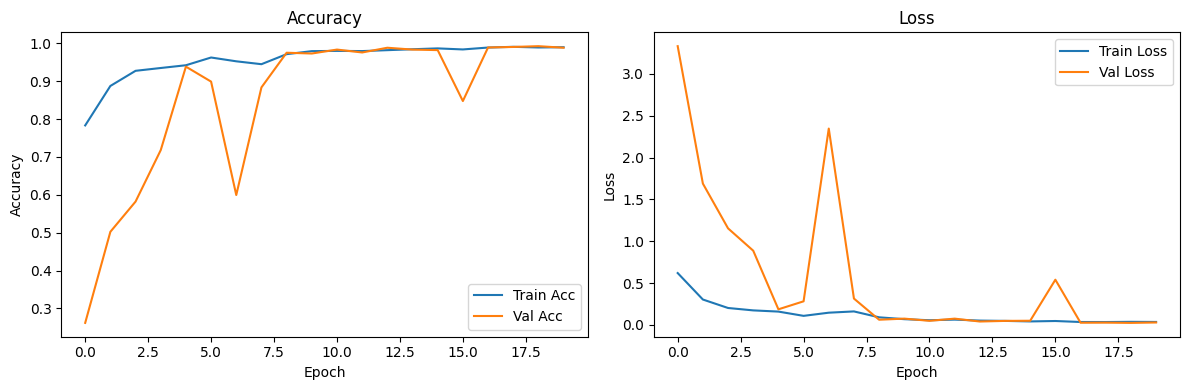

In [ ]:

#  Visualisation courbes entraînement
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Accuracy")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
#  Évaluation sur le test set
results = model.evaluate(test_gen, steps=len(test_gen), verbose=1)
for name, val in zip(model.metrics_names, results):
    print(f"{name.capitalize():12}: {val:.4f}")


57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 113ms/step - accuracy: 0.8027 - loss: 0.6070
Loss        : 0.2676
Compile_metrics: 0.9125


57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 114ms/step

Classification report:
               precision    recall  f1-score   support

   Black Rot       1.00      0.67      0.80       472
        ESCA       0.79      1.00      0.88       480
     Healthy       1.00      1.00      1.00       423
 Leaf Blight       0.94      1.00      0.97       430

    accuracy                           0.91      1805
   macro avg       0.93      0.92      0.91      1805
weighted avg       0.93      0.91      0.91      1805

Loss globale test (categorical_crossentropy) : 0.2676


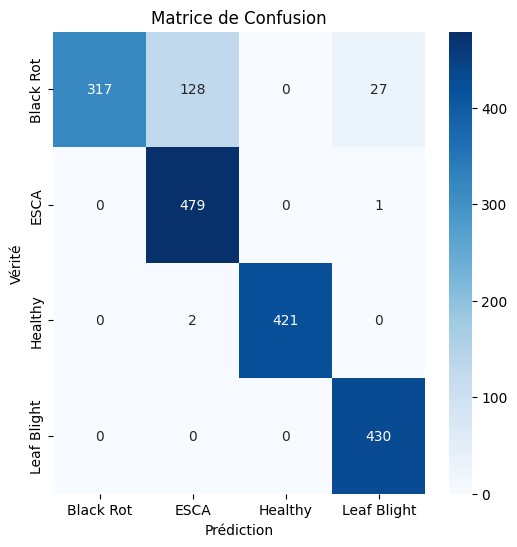

In [14]:
# Cell 8 : Matrice de confusion et rapport classification
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.losses import CategoricalCrossentropy
import seaborn as sns

test_gen.reset()
y_prob = model.predict(test_gen, verbose=1)
y_pred = np.argmax(y_prob, axis=1)
y_true = test_gen.classes

print("\nClassification report:\n", classification_report(y_true, y_pred, target_names=class_names))
cm = confusion_matrix(y_true, y_pred)

# Calcul de la loss globale sur le test set
# y_true doit être one-hot, or test_gen.classes donne des entiers. On convertit :
import tensorflow as tf

y_true_onehot = tf.keras.utils.to_categorical(y_true, num_classes=len(class_names))
loss_fn = CategoricalCrossentropy()
test_loss = loss_fn(y_true_onehot, y_prob).numpy()
print(f"Loss globale test (categorical_crossentropy) : {test_loss:.4f}")

# Graphique de la matrice de confusion

plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title("Matrice de Confusion")
plt.xlabel("Prédiction")
plt.ylabel("Vérité")
plt.show()


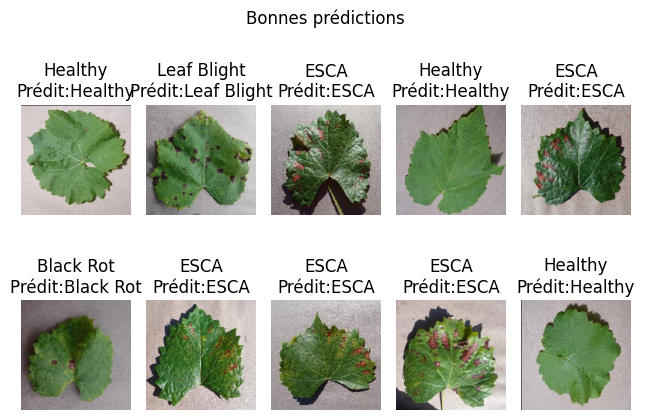

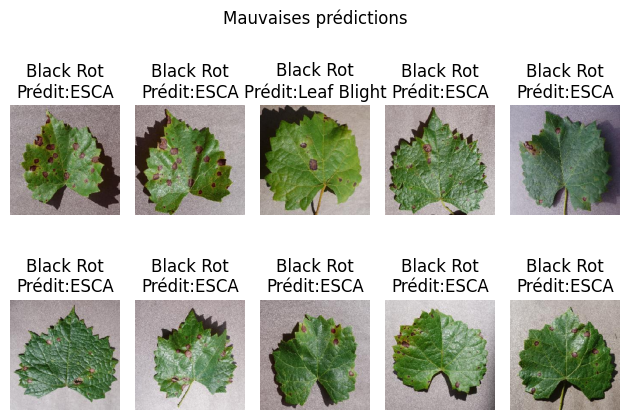

In [ ]:
#  Visualisation prédictions correctes/incorrectes
import random

def plot_predictions(gen, y_true, y_pred, class_names, correct=True, n=10):
    idxs = np.where(y_true == y_pred)[0] if correct else np.where(y_true != y_pred)[0]
    if len(idxs) == 0:
        print("Aucune image à afficher.")
        return
    n_display = min(n, len(idxs))
    sample = np.random.choice(idxs, n_display, replace=False)
    gen.reset()
    Xs, Ys = [], []
    for _ in range(len(gen)):
        xb, yb = next(gen)
        Xs.append(xb)
        Ys.append(yb)
    X_all = np.vstack(Xs)
    for i, idx in enumerate(sample):
        plt.subplot(2, 5, i+1)
        plt.imshow(X_all[idx])
        plt.title(f"{class_names[y_true[idx]]}\nPrédit:{class_names[y_pred[idx]]}")
        plt.axis('off')
    plt.suptitle("Bonnes prédictions" if correct else "Mauvaises prédictions")
    plt.tight_layout()
    plt.show()

plot_predictions(test_gen, y_true, y_pred, class_names, correct=True, n=10)
plot_predictions(test_gen, y_true, y_pred, class_names, correct=False, n=10)


## Analyse des résultats & pistes d'amélioration

### Analyse globale

- Le CNN entraîné from scratch obtient de **très bonnes performances** :  
  - **Accuracy test : ~91%**
  - **Loss globale test : ~0.27**
- Certaines classes (Healthy, Leaf Blight) sont très bien reconnues (précision et rappel proches de 1).
- Quelques confusions persistent, en particulier entre **Black Rot** et **ESCA**, visibles dans la matrice de confusion et les f1-scores.
- Les exemples de bonnes et mauvaises prédictions montrent que le modèle apprend la majorité des cas, mais reste perfectible sur certaines variétés de feuilles ou de symptômes.

### Limites du modèle

- **Temps d'entraînement élevé :** Environ 1h pour converger à de bonnes performances.
- **Nécessite beaucoup d'epochs et de puissance de calcul** pour bien apprendre toutes les classes.
- **Risque d'overfitting** si le nombre d'images par classe ou la diversité n'est pas suffisante.

### Pistes d'amélioration

- **Transfer Learning :**  
  Utiliser un modèle pré-entraîné (ResNet, EfficientNet, etc.) comme extracteur de features, puis entraîner uniquement la dernière couche dense.  
  Cela permet de gagner énormément de temps, et d’obtenir de très bonnes performances dès les premières epochs, surtout avec peu de données.
- **Fine-Tuning :**  
  Après un premier entraînement rapide (toutes les couches gelées sauf la dernière), on peut “dégeler” les dernières couches du backbone et les réentraîner avec un taux d’apprentissage plus bas, pour améliorer encore la précision et l’adaptation au dataset.
- **Augmentation de données plus avancée :**  
  Enrichir la data augmentation (blur, contrast, brightness, flipping, crop, etc.) pour eviter l'overfiting.
- **Collecte de données :**  
  Ajouter des images plus variées (différentes lumières, angles, stades de maladies) pour améliorer la généralisation.
- **Analyse d’erreurs** :  
  Étudier les cas de confusion dans la matrice de confusion pour ajuster le modèle ou le dataset.

---

**Conclusion :**  
Le CNN from scratch prouve l’efficacité de l’apprentissage profond sur ce type de données, mais la comparaison avec le transfer learning et le fine-tuning mettra en évidence l’intérêt de ces méthodes pour l’industrialisation et la rapidité de mise en œuvre.
